# Solve *Easy21* by TD(&#955;)

In [1]:
import itertools
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

sns.set()
%matplotlib inline

In [2]:
from plot_utils import draw_heatmap
from easy21 import Easy21, HIT, STICK

In [3]:
env = Easy21()

## Explore policy and stepsize function

In [4]:
def EpsilonGreedyWithDecay(decay_rate, epsilon0):
    def epsilon_greedy_with_decay(qvalues, visits):
        epsilon = epsilon0 / (1.0 + decay_rate * sum(visits))
        n_actions = len(qvalues)
        probs = [epsilon / n_actions] * n_actions
        #maxidx = qvalues.index(max(qvalues))
        maxidx = np.argmax(qvalues)
        probs[maxidx] += (1 - epsilon)
        return probs
    return epsilon_greedy_with_decay

explore_policy = EpsilonGreedyWithDecay(0.01, 1.0)

In [5]:
def StepSizeWithDecay(decay_rate, alpha0):
    def step_size_with_decay(visit, *args, **kwargs):
        return alpha0 / (1.0 + decay_rate * visit)
    return step_size_with_decay

stepsize = StepSizeWithDecay(1.0, 1.0)

## Sarsa(&#955;) algorithm

1. Initialize Q function.
2. Set $t=0$ and initialize $s_t$.
3. Set $e(s, a)=0$ for all states and action $s, a$.
4. Choose action $a_t$ by exploration policy to $s_t$.
5. Take $a_t$ and observe $r_{t+1}, s_{t+1}$.
6. Choose action $a_{t+1}$ by exploration policy to $s_{t+1}$.
7. Update $e$ by
$$
e(s) \leftarrow \begin{cases}
  \gamma\lambda e(s, a) + 1  && \text{if } s = s_t \text{ and } a = a_t\\
  \gamma\lambda e(s, a)      && \text{otherwise}
\end{cases}
$$
8. For each $(s, a)$, update Q function by
$$
Q(s, a) \leftarrow Q(s, a) + \alpha \cdot  e(s, a) \left( r_{t+1} + \gamma Q \left( s_{t+1}, a_{t+1} \right) - Q \left( s_t, a_t \right) \right)
$$
9. If $s_{t+1}$ is not terminal, set $t \leftarrow t+1$ and go to 5.
10. Finish if maximum iteration has reached, otherwise go to 2.

Remarks

* $e(s, a)$ is called the *eligibility trace* for state-action pairs. It tracks the contribution of $(s, a)$ to the current value.
* The Q function is update not only for the current observation, but for all state-actions every period. In the implementation, we do this by vectorized operations using `numpy`.

In [6]:
def sarsa_lambda_episode(qs, ns, env, policy, stepsize, gamma, lambda_):
    """
    Run an episode for Sarsa(lambda) control.
    
    qs and ns are array of shape (s1, s2, ..., a). Where s1, s2,... are state variables and a is action.
    We assume that state is a tuple of nonnegative integers, and action is an nonnegative integer, and
    use them as indices as-is.
    """
    s = env.reset()
    es = np.zeros_like(qs)
    
    prob = policy(qs[s], ns[s])
    a = random.choices(range(env.num_actions), prob)[0]
    while True:
        s1, r, done, _ = env.step(a)
        alpha = stepsize(ns[(*s, a)])
        ns[(*s, a)] += 1.0
        
        es *= (gamma*lambda_)
        es[(*s, a)] += 1.0
        if done:
            delta = r - qs[(*s, a)]
            qs += alpha * es * delta
            break
        else:
            prob = policy(qs[s1], ns[s1])
            a1 = random.choices(range(env.num_actions), prob)[0]
            delta = r + gamma * qs[(*s1, a1)] - qs[(*s, a)]
            qs += alpha * es * delta
            s, a = s1, a1

In [7]:
# We add index 0, which is not used by the algorithm.
# By doing so states match the indices exactly.
qs = np.zeros((22, 11, 2))
ns = np.zeros((22, 11, 2))

In [8]:
for i in tqdm(range(10**6)):
    sarsa_lambda_episode(qs, ns, env, explore_policy, stepsize, 1.0, 0.5)

C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_916/4003510165.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(10**6)):


  0%|          | 0/1000000 [00:00<?, ?it/s]

In [9]:
def to_state_value(qs):
    return np.max(qs, axis=-1)

def to_policy(qs):
    return np.argmax(qs, axis=-1)

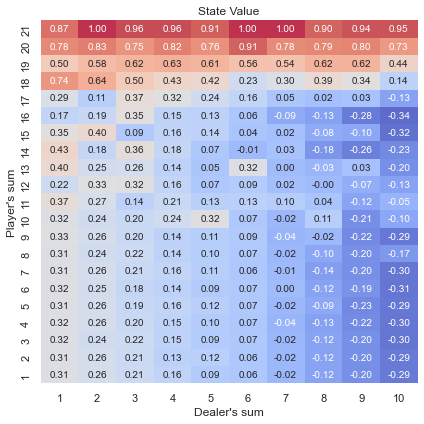

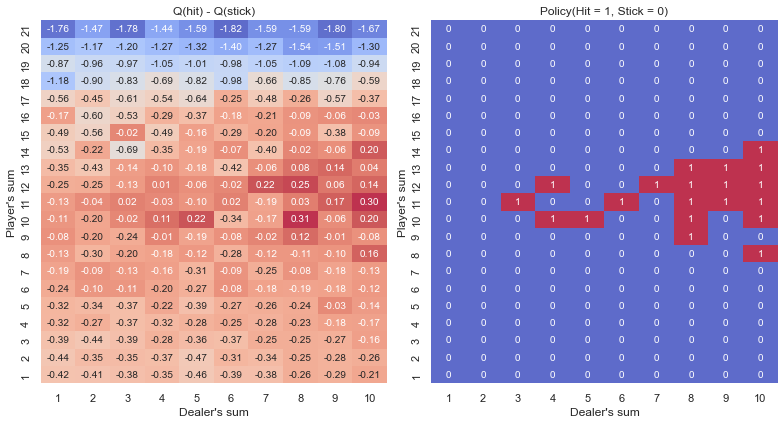

In [10]:
V = to_state_value(qs)

fig, ax = plt.subplots(figsize=(6, 6))
draw_heatmap(V[1:, 1:], ax=ax, title="State Value")
fig.tight_layout()

q_diff = qs[:, :, 1] - qs[:, :, 0]
policy = to_policy(qs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
draw_heatmap(q_diff[1:, 1:], ax=ax1, title="Q(hit) - Q(stick)")
draw_heatmap(policy[1:, 1:], ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()
None

## Compare to the DP result

In [11]:
f = np.load("result/dp.npz")
Q_dp = f["Q"]
Q_dp.shape

(21, 10, 2)

In [12]:
maes = {}
for lambda_ in np.arange(0.0, 1.1, 0.1):
    lambda_ = np.round(lambda_, decimals=1)  # to avoid small deviation like 0.30000000000000004
    clear_output(wait=True)
    print("lambda =", lambda_)
    qs = np.zeros((22, 11, 2))
    ns = np.zeros((22, 11, 2))
    mae = []
    for i in tqdm(range(10**7)):
        sarsa_lambda_episode(qs, ns, env, explore_policy, stepsize, 1.0, lambda_)
        if (i + 1) % 1000 == 0:
            mae.append(np.mean(np.abs(qs[1:, 1:] - Q_dp)))
            print("\rIter #%d, MAE = %.6f" % (i+1, mae[-1]), end="")
    maes[lambda_] = mae

lambda = 1.0


  0%|          | 0/10000000 [00:00<?, ?it/s]

Iter #345000, MAE = 0.104121

Iter #10000000, MAE = 0.069051

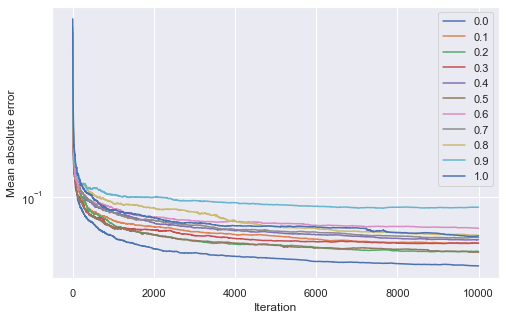

In [13]:
mae_df = pd.DataFrame(maes)

fig, ax = plt.subplots(figsize=(8, 5))
mae_df.plot(ax=ax)
ax.set_xlabel("Iteration")
ax.set_ylabel("Mean absolute error")
ax.set_yscale("log")

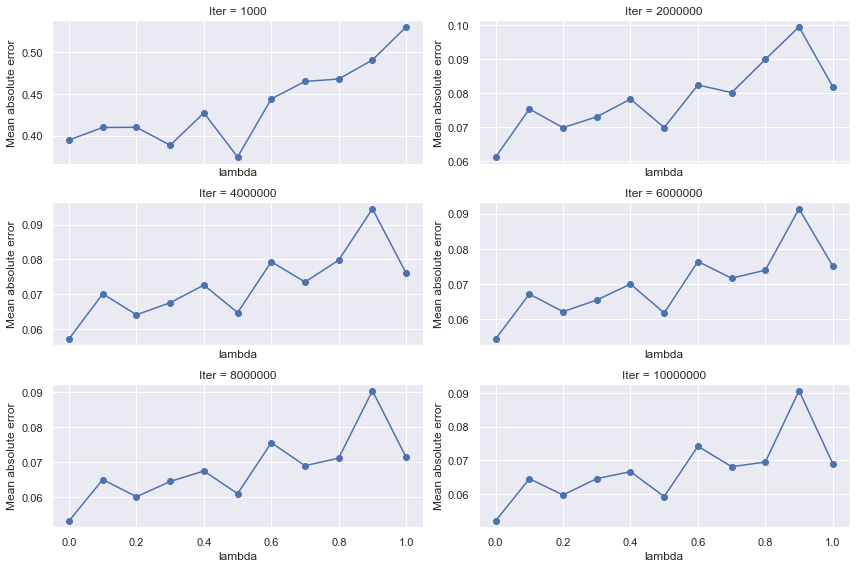

In [14]:
iters = np.linspace(0, len(mae_df)-1, num=6, dtype=int)
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=False)
for i, j in itertools.product(range(3), range(2)):
    k = iters[2*i + j]
    it = 1000 * (k + 1)
    ax = axes[i][j]
    ax.plot(mae_df.iloc[k], marker="o")
    ax.set_xlabel("lambda")
    ax.set_ylabel("Mean absolute error")
    ax.set_title("Iter = %d" % it)
fig.tight_layout()
None

*Remark: We observe generally smaller $\lambda$ is preferred (Perhaps the good result with $\lambda = 0.4$ is just a chance?)*

## Off-policy TD(&#955;)

We will implement two variants of off-policy TD(&#955;) algorithms, Watkin's and Na&#239;ve Q(&#955;).
When extending Q-learning with eligibility traces, consideration taken is the treatment of exploratory actions.
* **Watkin's Q(&#955;)**: Zero-out all eligibility traces when non-greedy action is taken.
* **Na&#239;ve Q(&#955;)**: Keep all traces as for Sarasa.

## Watkins's and Na&#239;ve Q(&#955;)

1. Initialize Q function.
2. Set $t=0$ and initialize $s_t$.
3. Set $e(s, a)=0$ for all states and actions $s, a$.
4. Choose action $a_t$ by exploration policy to $s_t$.
5. Take $a_t$ and observe $r_{t+1}, s_{t+1}$.
7. (Watkins's Only) If $Q(s_{t}, a_{t}) \not= \max_a Q(s_{t}, a)$, set $e(s, a) = 0$ for all $s, a$.
8. Update $e$ by
$$
e(s, a) \leftarrow \begin{cases}
  \gamma\lambda e(s, a) + 1  && \text{if } s = s_t \text{ and } a = a_t\\
  \gamma\lambda e(s, a)      && \text{otherwise}
\end{cases}
$$
9. For each $(s, a)$, update Q function by
$$
Q(s, a) \leftarrow Q(s, a) + \alpha \cdot  e(s, a) \left( r_{t+1} + \gamma \max_a Q \left( s_{t+1}, a \right) - Q \left( s_t, a_t \right) \right)
$$
10. If $s_{t+1}$ is not terminal, set $t \leftarrow t+1$ and go to 4.
10. Finish if maximum iteration has reached, otherwise go to 2.


In [15]:
def q_lambda_episode(qs, ns, env, policy, stepsize, gamma, lambda_, watkins=True):
    """
    Run an episode for Q(lambda) control.
    
    qs and ns are array of shape (s1, s2, ..., a). Where s1, s2,... are state variables and a is action.
    We assume that state is a tuple of nonnegative integers, and action is an nonnegative integer, and
    use them as indices as-is.
    """
    s = env.reset()
    es = np.zeros_like(qs)
    
    prob = policy(qs[s], ns[s])
    while True:
        a = random.choices(range(env.num_actions), prob)[0]
        s1, r, done, _ = env.step(a)
        alpha = stepsize(ns[(*s, a)])
        ns[(*s, a)] += 1.0
        
        if watkins and qs[(*s, a)] != max(qs[s]):
            es[:] = 0.0
        es[(*s, a)] += 1.0
        
        if done:
            delta = r - qs[(*s, a)]
            qs += alpha * es * delta
            break
        else:
            prob = policy(qs[s1], ns[s1])
            delta = r + gamma * max(qs[s1]) - qs[(*s, a)]
            qs += alpha * es * delta
            es *= (gamma*lambda_)            
            s = s1

C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_916/2317010965.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(10**6)):


  0%|          | 0/1000000 [00:00<?, ?it/s]

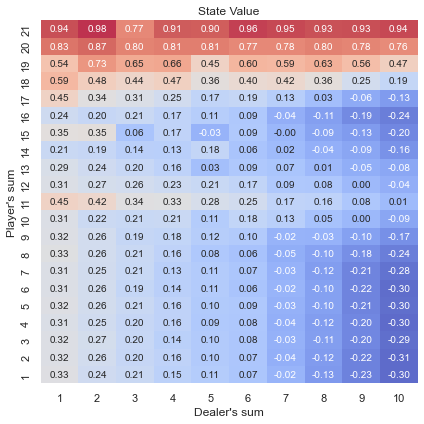

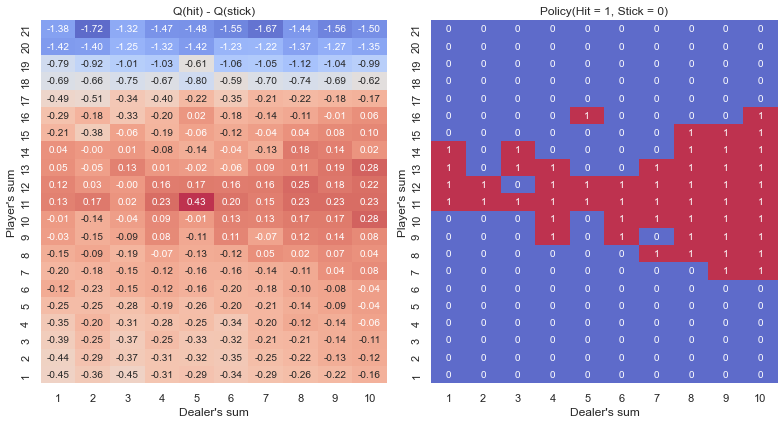

In [16]:
# Watkins's Q
qs = np.zeros((22, 11, 2))
ns = np.zeros((22, 11, 2))

for i in tqdm(range(10**6)):
    q_lambda_episode(qs, ns, env, explore_policy, stepsize, 1.0, 0.5, watkins=True)


V = to_state_value(qs)
fig, ax = plt.subplots(figsize=(6, 6))
draw_heatmap(V[1:, 1:], ax=ax, title="State Value")
fig.tight_layout()

q_diff = qs[:, :, 1] - qs[:, :, 0]
policy = to_policy(qs)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
draw_heatmap(q_diff[1:, 1:], ax=ax1, title="Q(hit) - Q(stick)")
draw_heatmap(policy[1:, 1:], ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()
None

C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_916/3838292771.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(10**6)):


  0%|          | 0/1000000 [00:00<?, ?it/s]

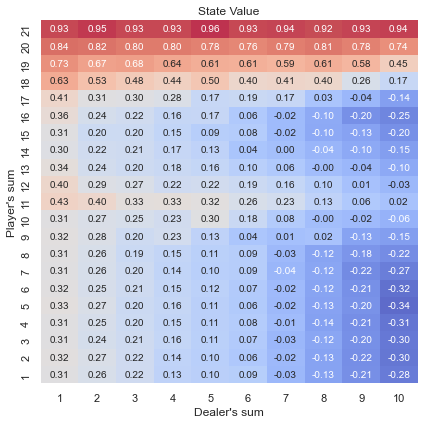

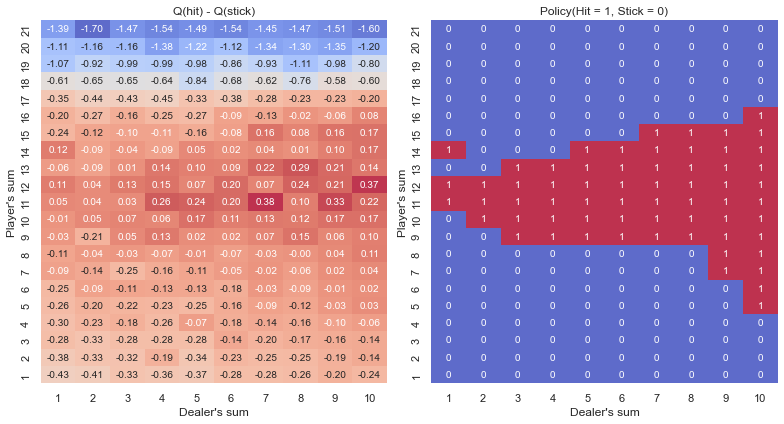

In [17]:
# Naive Q
qs = np.zeros((22, 11, 2))
ns = np.zeros((22, 11, 2))

for i in tqdm(range(10**6)):
    q_lambda_episode(qs, ns, env, explore_policy, stepsize, 1.0, 0.5, watkins=False)


V = to_state_value(qs)
fig, ax = plt.subplots(figsize=(6, 6))
draw_heatmap(V[1:, 1:], ax=ax, title="State Value")
fig.tight_layout()

q_diff = qs[:, :, 1] - qs[:, :, 0]
policy = to_policy(qs)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
draw_heatmap(q_diff[1:, 1:], ax=ax1, title="Q(hit) - Q(stick)")
draw_heatmap(policy[1:, 1:], ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()
None

*Remark: Both Q(&#955;) methods seem to be working well.*

## Compare to the DP result

In [21]:
maes = {}
for lambda_, watkins in itertools.product(np.arange(0.0, 1.1, 0.1), [True, False]):
    lambda_ = np.round(lambda_, decimals=1)  # to avoid small deviation like 0.30000000000000004
    clear_output(wait=True)
    print("lambda, watkins =", lambda_, watkins)
    qs = np.zeros((22, 11, 2))
    ns = np.zeros((22, 11, 2))
    mae = []
    for i in tqdm(range(10**7)):
        q_lambda_episode(qs, ns, env, explore_policy, stepsize, 1.0, lambda_, watkins)
        if (i + 1) % 1000 == 0:
            mae.append(np.mean(np.abs(qs[1:, 1:] - Q_dp)))
            print("\rIter #%d, MAE = %.6f" % (i+1, mae[-1]), end="")
    maes[(watkins, lambda_)] = mae

lambda, watkins = 1.0 False


Iter #10000000, MAE = 0.047695


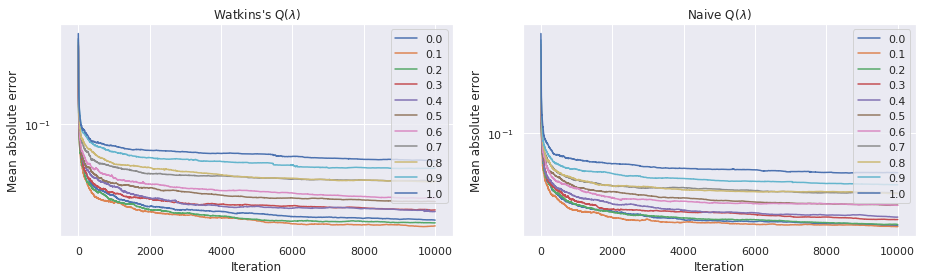

In [22]:
mae_df = pd.DataFrame(maes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

mae_df[True].plot(ax=ax1)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Mean absolute error")
ax1.set_yscale("log")
ax1.set_title("Watkins's Q($\lambda$)")

mae_df[False].plot(ax=ax2)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Mean absolute error")
ax2.set_yscale("log")
ax2.set_title("Naive Q($\lambda$)")
fig.tight_layout()
None

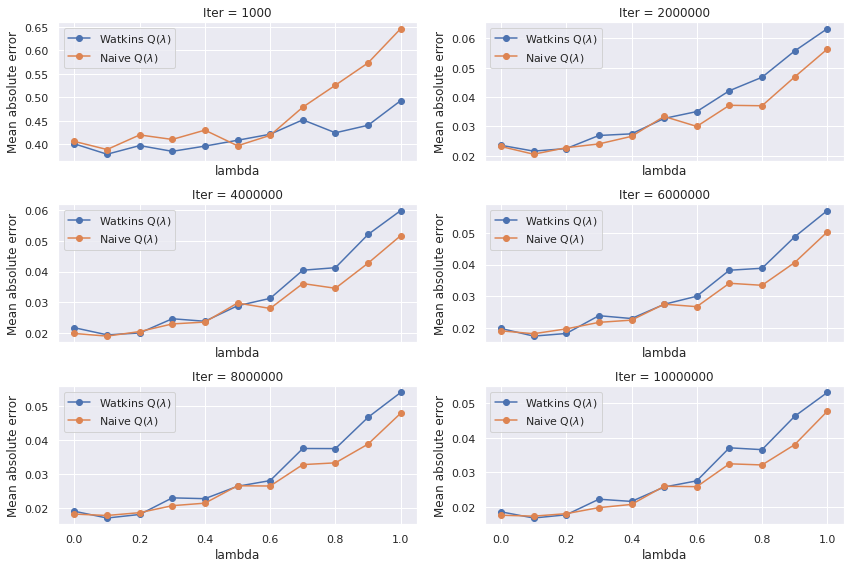

In [23]:
iters = np.linspace(0, len(mae_df)-1, num=6, dtype=int)
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=False)
for i, j in itertools.product(range(3), range(2)):
    k = iters[2*i + j]
    it = 1000 * (k + 1)
    ax = axes[i][j]
    ax.plot(mae_df[True].iloc[k], marker="o", label="Watkins Q($\lambda$)")
    ax.plot(mae_df[False].iloc[k], marker="o", label="Naive Q($\lambda$)")
    ax.set_xlabel("lambda")
    ax.set_ylabel("Mean absolute error")
    ax.set_title("Iter = %d" % it)
    ax.legend()
fig.tight_layout()
None

*Remark: Both Q(&#955;) methods exhibit better results than Sarsa(&#955;). In this experiment, we tend to prefer small $\lambda$ and Naive Q(&#955;) exhibits slightly better performance than Watkins.*

In [26]:
mae_df.tail()

,True,False,True,False,True,False,True,False,True,False,...,True,False,True,False,True,False,True,False,True,False
,0.0,0.0,0.1,0.1,0.2,0.2,0.3,0.3,0.4,0.4,...,0.6,0.6,0.7,0.7,0.8,0.8,0.9,0.9,1.0,1.0
9995,0.018607,0.017619,0.016802,0.017370,0.017724,0.018053,0.022232,0.019802,0.021594,0.020731,...,0.027557,0.025870,0.037120,0.032483,0.036602,0.032162,0.046234,0.038030,0.053117,0.047663
9996,0.018603,0.017621,0.016796,0.017359,0.017736,0.018053,0.022228,0.019803,0.021604,0.020731,...,0.027552,0.025871,0.037120,0.032481,0.036601,0.032163,0.046236,0.038035,0.053117,0.047662
9997,0.018604,0.017611,0.016800,0.017364,0.017738,0.018056,0.022228,0.019812,0.021604,0.020739,...,0.027559,0.025857,0.037121,0.032485,0.036598,0.032165,0.046236,0.038033,0.053129,0.047697
9998,0.018600,0.017614,0.016809,0.017353,0.017740,0.018058,0.022235,0.019811,0.021607,0.020738,...,0.027571,0.025874,0.037119,0.032485,0.036596,0.032163,0.046231,0.038032,0.053129,0.047692
9999,0.018600,0.017616,0.016807,0.017352,0.017742,0.018067,0.022249,0.019818,0.021610,0.020739,...,0.027566,0.025875,0.037121,0.032493,0.036586,0.032162,0.046238,0.038031,0.053129,0.047695
